# Exploring Evolutionary Algorithms w/ DEAP

In this section we define a set of utilities to download stock data and calculate financial metrics to be used for our downstream Evolutionary Algorithm. 

In [4]:
# Utilities
from datetime import datetime
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
import pickle

def get_ticker_data(ticker: str, start: datetime, end: datetime) -> pd.DataFrame:
    """ Download stock datafrom Yahoo Stocks. Method takes in a stock symbol, start date and end date and
        returns 
    """
    return pdr.get_data_yahoo(ticker, start=start, end=end)

def calculate_cagr(df: pd.DataFrame) -> float:
    days = (df.index[-1] - df.index[0]).days
    return ((((df['Adj Close'][-1]) / df['Adj Close'][1])) ** (365.0/days)) - 1


# Generate cache of stock data. For simulation we'll sample 150 stocks from the 
# SP500 and gather relevant data and calculate the compound annual growth rate.

# symbols = pd.read_csv("data/sp500_symbols.csv")["Symbol"].tolist()

# stock_subset = np.random.choice(symbols, size=150)

# stock_map = {}
# eval_start = datetime(2015, 1, 1) 
# eval_end =  datetime(2019, 12, 31)
        
# for stock in tqdm(stock_subset):
#     try:
#         df = get_ticker_data(stock, eval_start, eval_end)
#         cagr = calculate_cagr(df)
#         stock_map[stock] = {"df": df, "cagr": cagr}
#     except:
#         # Not all stocks in our sample will have data going back to 2015. We'll skip those stocks
#         continue

# pickle.dump(stock_map, open("data/stock_data.pkl", "wb"))
stock_map = pickle.load(open("data/stock_data.pkl", "rb"))

## Create Stock Info Class
Next we create a class that will be used to generate random portfolios and look up CAGR values. DEAP requires a generator function to create individuals. In our simulation an individual is portfolio consisting of randomly selcted stocks. 

In [5]:
class StockManager():

    def __init__(self, portfolio_size: int, stock_map: dict):        
        self.portfolio_size = portfolio_size

        self.stock_info = stock_map
        self.stocks = sorted(self.stock_info.keys()) # Dict keys are unsorted. Sorting ensures deterministic indices
        self.stock_total = len(self.stocks)

        # convert stocks to ids
        self.stock2idx = {stock: idx for idx, stock in enumerate(self.stocks)}
        self.idx2stock = {idx:stock for idx, stock in enumerate(self.stocks)} 

    def lookup_stock(self, idx: int) -> str:
        return self.idx2stock[idx]

    def lookup_stock_cagr(self, idx) -> float:
        return self.stocks_info[self.lookup_stock(idx)]["cagr"]
    
    def generate_random_stocks(self) -> List[str]:
        """ Sample stocks from stock list to fill portfolio. """
        return np.random.choice(self.stocks, size = self.portfolio_size)
    
    def score_portfolio(self, portfolio: List[int]) -> float:
        cagr_total = 0
        for idx, val in enumerate(portfolio):
            cagr_total += self.stock_info[self.idx2stock[idx]]["cagr"] * val
        return cagr_total

    def generate_random_portfolio(self) -> List[int]:
        """ Generate a random portfolio. Portfolio is represented as indexed mask
            where each element index corresponds to a stock in the overall stock list.
            A 1 indicates a stock is part of the portfolio and a 0 indicate it is absent. 
        """
        random_stocks = self.generate_random_stocks()
        portfolio = [0] * len(self.stocks)
        for stock in random_stocks:
            portfolio[self.stock2idx[stock]] = 1
        return portfolio

# Running the EA algorithm

##  1. Register Population generation functions

In [9]:
# 1. Create Stock manager object
stock_manager = StockManager(portfolio_size=20, stock_map=stock_map)

In [10]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import random

POPULATION_SIZE = 50 # Number of randomly generated portfolios
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual

MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 1

def generate_random_dist(size: int) -> List[float]:
    return np.random.dirichlet(np.ones(size),size=1).tolist()[0]

In [11]:
# 1. Register function to create populations

# a. create toolbox object and regist objective strategy (i.e. maximization)
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# b. Register function for generating individuals
toolbox.register("attr_bool", random.randint, 0,1)
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=stock_manager.stock_total)

# c. Register function for generating a population 
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print(toolbox.population(n=1))

[[1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1]]


## 2. Register Evaluation and Genetic Algorithm functions

In [12]:
# Register Evaluation and genetic operators
def evaluate_portfolio(portfolio: List[int]) -> tuple:
    """ Return the total CAGR for each portfolio """
    return stock_manager.score_portfolio(portfolio),

toolbox.register("evaluate", evaluate_portfolio)

In [13]:
# Register Genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)

## 3. Run Simulation

In [15]:
pop = toolbox.population(n=100)
hof = tools.HallOfFame(1)
 
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, 
                                   ngen=100,stats=stats, halloffame=hof, verbose=True)


gen	nevals	avg    	min    	max    
0  	100   	8.88271	5.57835	12.0491
1  	63    	9.78955	7.57065	12.5327
2  	55    	10.6034	8.64189	13.1156
3  	58    	11.3938	9.70635	13.1156
4  	60    	11.9823	9.96433	13.2948
5  	60    	12.5548	10.5677	14.0175
6  	62    	12.8407	10.1967	14.2178
7  	62    	13.2291	11.7748	14.4315
8  	58    	13.3697	10.8023	14.4864
9  	64    	13.5917	11.0662	14.644 
10 	60    	13.9716	12.0191	14.9595
11 	64    	14.1247	12.1687	15.1353
12 	45    	14.445 	11.8646	15.346 
13 	58    	14.6392	12.5109	15.346 
14 	58    	14.7544	12.5306	15.5008
15 	64    	14.8583	12.4267	15.5668
16 	62    	14.9142	12.1089	15.6015
17 	49    	15.1585	13.1369	15.7316
18 	55    	15.1676	12.8059	15.9549
19 	72    	15.2461	12.3044	15.9495
20 	63    	15.4572	12.0067	15.9731
21 	51    	15.4542	13.2916	16.1067
22 	64    	15.4954	12.8513	16.125 
23 	56    	15.6725	12.438 	16.2937
24 	63    	15.6953	12.7488	16.4455
25 	64    	15.8583	14.0872	16.5022
26 	63    	15.8857	13.0137	16.5022
27 	57    	15.9297	1

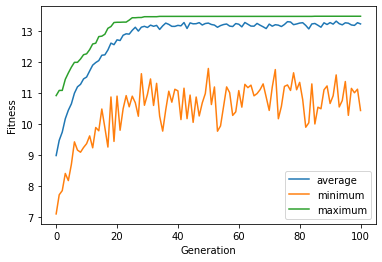

In [110]:
import matplotlib.pyplot as plt
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show() 